In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import requests
import numpy as np
import io
import seaborn as sns
import pandas as pd

# Extract file ID
file_url = "https://drive.google.com/file/d/1UAju0um6OwhUykk_7ESLt8KWFDsla9Vy/view?usp=drive_link"
file_id = file_url.split("/")[-2]

# Download file
url = f"https://drive.google.com/uc?id={file_id}&export=download"
response = requests.get(url)
content = response.content

# Read the CSV file into a DataFrame
df = pd.read_csv(io.StringIO(content.decode('utf-8')))

In [ ]:
# Fix columns that may have commas
cols= ['quota', 'bids_success', 'bids_received', 'premium']

for col in cols:
    # Remove commas
    df[col] = df[col].astype(str).str.replace(',', '')
    # Convert to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Manipulate to remove that month column and replace with two separate colums for month and year
df['month'] = pd.to_datetime(df['month'])
df['year_num'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month
df = df.drop(columns=['month'])

# Encode the vehicle category class to be numerical
mapping = {
    'Category A': 0,
    'Category B': 1,
    'Category C': 2,
    'Category D': 3,
    'Category E': 4
}
df['vehicle_class'] = df['vehicle_class'].map(mapping)

# Select features and target variable
X = df[['year_num', 'month_num', 'bidding_no', 'vehicle_class', 'quota', 'bids_received']]
Y = df['premium']

In [ ]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=57)

In [ ]:
# Parameter grid for tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Base model
rf_model = RandomForestRegressor(
    n_estimators=100,
    bootstrap=True,
    max_features='sqrt',
    random_state=57
)

# GridSearchCV setup (5-fold cross-validation)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)

# Train the model
rf_model.fit(X_train, Y_train)

RandomForestRegressor(max_features='sqrt', random_state=57)

In [ ]:
# Predict on the test set
Y_pred = rf_model.predict(X_test)

# Evaluation of accuracy
mae = mean_absolute_error(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 4534.075652173912
RMSE: 6663.766662268975
R2: 0.9586305569823756


         Feature  Importance
3  vehicle_class    0.397393
0       year_num    0.260905
4          quota    0.195281
5  bids_received    0.120570
1      month_num    0.022697
2     bidding_no    0.003154


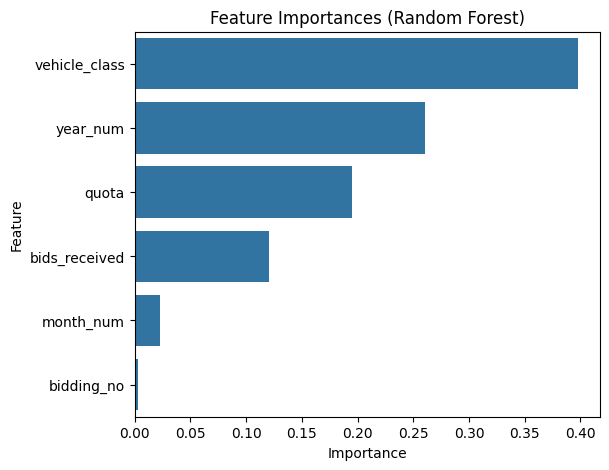

In [ ]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feat_imp_df)

# Visualise feature importance
plt.figure(figsize=(6, 5))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances (Random Forest)')
plt.show()

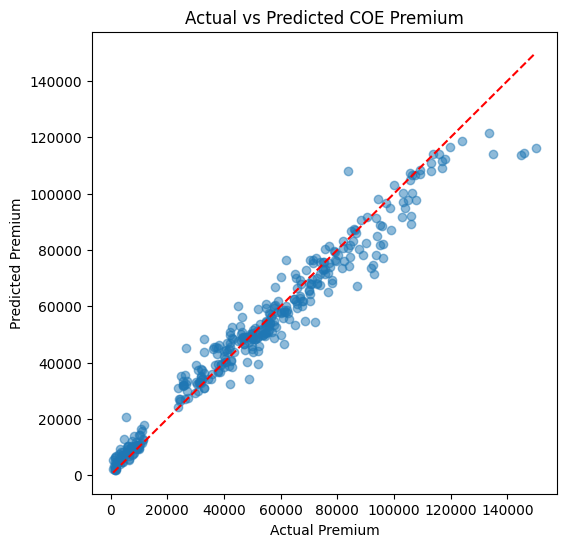

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Y_test, Y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  # diagonal line
plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')
plt.title('Actual vs Predicted COE Premium')
plt.show()

In [ ]:
# User Interface

# User interface (no clear_output)

# Mapping from letter to numeric value
vehicle_mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4
}

# Year: >= 2010
while True:
    try:
        year_num = int(input("Enter Year (2010 or later): "))
        if year_num >= 2010:
            break
        else:
            print("Invalid year. Please enter a year from 2010 onwards.")
    except ValueError:
        print("Please enter a valid number for the year.")

# Month: 1–12
while True:
    try:
        month_num = int(input("Enter Month (1-12): "))
        if 1 <= month_num <= 12:
            break
        else:
            print("Invalid month. Please enter a number from 1 to 12.")
    except ValueError:
        print("Please enter a valid number for the month.")

# Bidding number: 1 or 2
while True:
    try:
        bidding_no = int(input("Enter Bidding Number (1 or 2): "))
        if bidding_no in [1, 2]:
            break
        else:
            print("Invalid bidding number. Please enter 1 or 2.")
    except ValueError:
        print("Please enter a valid number (1 or 2).")

# Vehicle class: A–E
while True:
    vehicle_letter = input("Enter Vehicle Class (A, B, C, D, or E): ").strip().upper()
    if vehicle_letter in vehicle_mapping:
        vehicle_class = vehicle_mapping[vehicle_letter]
        break
    else:
        print("Invalid vehicle class. Please enter A, B, C, D, or E.")

# Quota: must be positive integer
while True:
    try:
        quota = int(input("Enter Vehicle Quota This Round: "))
        if quota > 0:
            break
        else:
            print("Quota must be a positive number.")
    except ValueError:
        print("Please enter a valid number for quota.")

# Bids received: must be positive integer
while True:
    try:
        bids_received = int(input("Enter Bids Received This Round: "))
        if bids_received > 0:
            break
        else:
            print("Bids received must be a positive number.")
    except ValueError:
        print("Please enter a valid number for bids received.")

# Prepare input and predict
input_df = pd.DataFrame([[
    year_num, month_num, bidding_no, vehicle_class, quota, bids_received
]], columns=X.columns)

prediction = rf_model.predict(input_df)

print(f"\nPredicted COE Premium: {prediction[0]:,.0f} SGD")


Enter Year (2010 or later): 2025
Enter Month (1-12): 1
Enter Bidding Number (1 or 2): 2
Enter Vehicle Class (A, B, C, D, or E): b
Enter Vehicle Quota This Round: 300
Enter Bids Received This Round: 200

Predicted COE Premium: 87,583 SGD
